In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import quandl

quandl.ApiConfig.api_key = 'gYyp7CLTPWqhbsyFNAN2'

selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']

data = quandl.get_table('WIKI/PRICES', ticker=selected, qopts={'columns': ['ticker', 'date', 'adj_close']},
                       date={'gte': '2014-1-1', 'lte': '2016-12-31'},
                       paginate=False)
data.head()

,ticker,date,adj_close
None,,,
0,WMT,2016-12-30,67.742045
1,WMT,2016-12-29,67.879254
2,WMT,2016-12-28,67.928257
3,WMT,2016-12-27,68.310482
4,WMT,2016-12-23,68.153672


In [2]:
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

data.head()

,ticker,date,adj_close
None,,,
0,WMT,2016-12-30,67.742045
1,WMT,2016-12-29,67.879254
2,WMT,2016-12-28,67.928257
3,WMT,2016-12-27,68.310482
4,WMT,2016-12-23,68.153672


In [3]:
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250
returns_annual

           ticker
adj_close  CNP       0.091859
           F        -0.007358
           GE        0.095399
           TSLA      0.204873
           WMT      -0.000943
dtype: float64

In [4]:
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250
cov_annual

adj_close                                        
ticker                 CNP         F        GE      TSLA       WMT
          ticker                                                  
adj_close CNP     0.040941  0.014076  0.015147  0.017508  0.010534
          F       0.014076  0.052813  0.021476  0.029219  0.011608
          GE      0.015147  0.021476  0.033564  0.022247  0.010747
          TSLA    0.017508  0.029219  0.022247  0.176760  0.012628
          WMT     0.010534  0.011608  0.010747  0.012628  0.032357

In [8]:
port_returns = []
port_volatility = []
stock_weights = []

num_assets = len(selected)
num_portfolios = 50000

# Set a random seed, for reprodicibility
np.random.seed(101)

for p in range(num_portfolios):
    
    # Calculate a random weight, and make it a percentage of 
    # all the weights calculated for this basket.
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    # Calculate the returns for this weighting of stocks, 
    # using the annual returns
    returns = np.dot(weights, returns_annual)
    
    # Calculate the volatility for this weighting of stocks, 
    # using the annual coveriance values
    # Effictively std. deviation
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    
    # Store the values for this portfolio
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    
# Add a dictionary for Returns and Risk values of each portfolio
portfolio = { 'Returns': port_returns, 'Volatility': port_volatility }

# Extend the dictionary, to accomdate each ticker and weight in the portfolio
for counter, symbol in enumerate(selected):
    portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weights]
                                     
# Finally! Make a DataFrame...
df = pd.DataFrame(portfolio)
                                     
# What's our data look like?
df.head()


,Returns,Volatility,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
0,0.040788,0.149496,0.261820,0.289335,0.014437,0.086964,0.347444
1,0.104291,0.176221,0.283065,0.104199,0.303335,0.244927,0.064474
2,0.079494,0.176328,0.195196,0.124019,0.064062,0.276685,0.340038
3,0.118147,0.206389,0.120722,0.043415,0.313581,0.378758,0.143523
4,0.058253,0.159980,0.434703,0.328493,0.030755,0.087453,0.118597


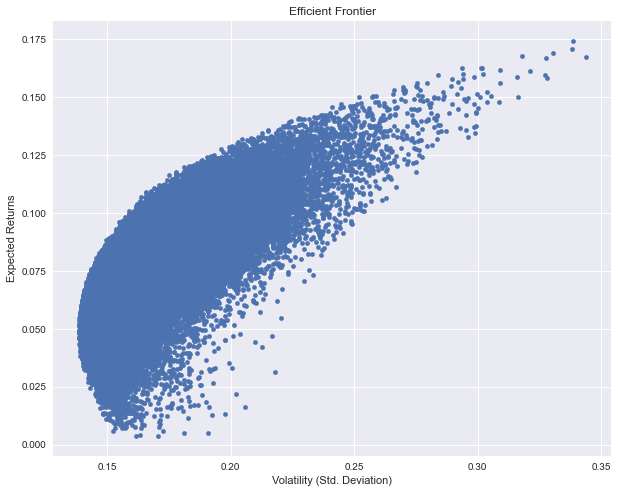

In [9]:
plt.style.use('seaborn')
df.plot.scatter(x='Volatility',y='Returns',figsize=(10,8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [11]:
port_returns = []
port_volatility = []
stock_weights = []

sharpe_ratio = []

num_assets = len(selected)
num_portfolios = 50000

np.random.seed(101)

for p in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    
    ratio = returns/volatility
    
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    
    sharpe_ratio.append(ratio)
    
    portfolio = { 'Returns': port_returns,
                  'Volatility': port_volatility,
                  'Sharpe Ratio': sharpe_ratio}
    
for counter, symbol in enumerate(selected):
    portfolio[symbol + 'Weight'] = [Weight[counter] for Weight in stock_weights]
    
df = pd.DataFrame(portfolio)

df.head()

,Returns,Volatility,Sharpe Ratio,CNPWeight,FWeight,WMTWeight,GEWeight,TSLAWeight
0,0.040788,0.149496,0.272835,0.261820,0.289335,0.014437,0.086964,0.347444
1,0.104291,0.176221,0.591821,0.283065,0.104199,0.303335,0.244927,0.064474
2,0.079494,0.176328,0.450830,0.195196,0.124019,0.064062,0.276685,0.340038
3,0.118147,0.206389,0.572448,0.120722,0.043415,0.313581,0.378758,0.143523
4,0.058253,0.159980,0.364128,0.434703,0.328493,0.030755,0.087453,0.118597


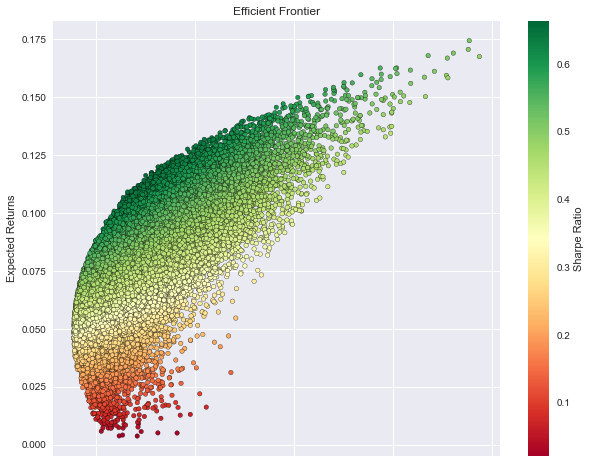

In [12]:
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10,8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

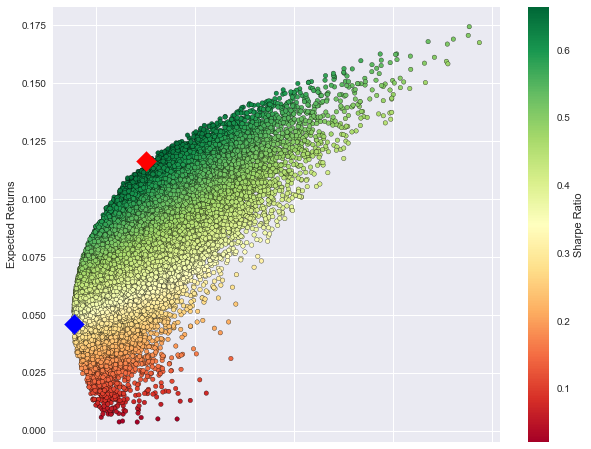

In [13]:
max_sharpe = df['Sharpe Ratio'].max()
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]

min_volatility = df['Volatility'].min()
min_volatility_portfolio = df.loc[df['Volatility'] == min_volatility]

plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10,8), grid=True)

plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'],
            c='red', marker='D', s=200)

plt.scatter(x=min_volatility_portfolio['Volatility'],
            y=min_volatility_portfolio['Returns'],
            c='blue', marker='D', s=200)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.show()


In [14]:
print(min_volatility_portfolio.T * 100)
print(sharpe_portfolio.T * 100)

                  17879
Returns        4.582751
Volatility    13.855189
Sharpe Ratio  33.076061
CNPWeight     24.032728
FWeight       10.465888
WMTWeight     25.776005
GEWeight       0.148727
TSLAWeight    39.576652
                  31209
Returns       11.614461
Volatility    17.504468
Sharpe Ratio  66.351407
CNPWeight     37.289012
FWeight        0.848195
WMTWeight     40.498721
GEWeight      21.145033
TSLAWeight     0.219038
